# Build Earthquake Catalog

In this final notebook, we read the matched-filter database, remove the multiple detections and write a clean earthquake catalog in a csv file.

In [1]:
import os
n_CPUs = 12
os.environ["OMP_NUM_THREADS"] = str(n_CPUs)

import BPMF
import glob
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from BPMF.data_reader_examples import data_reader_mseed
from tqdm import tqdm
from time import time as give_time


pd.set_option('display.width', 1000)


In [2]:
# PROGRAM PARAMETERS
NETWORK_FILENAME = "network.csv"
TEMPLATE_DB = "template_db"
MATCHED_FILTER_DB = "matched_filter_db"
OUTPUT_CSV_FILENAME = "final_catalog.csv"
OUTPUT_DB_FILENAME = "final_catalog.h5"
BACKPROJ_DB_FILENAME = "reloc_bp.h5"
CHECK_SUMMARY_FILE = False
PATH_MF = os.path.join(BPMF.cfg.OUTPUT_PATH, MATCHED_FILTER_DB)
DATA_FOLDER = "preprocessed_2_12"

In [3]:
# read network metadata
net = BPMF.dataset.Network(NETWORK_FILENAME)
net.read()

## Read the detected events' metadata for each template

In [4]:
# template filenames
template_filenames = glob.glob(os.path.join(BPMF.cfg.OUTPUT_PATH, TEMPLATE_DB, "template*"))
template_filenames.sort()

# initialize the template group
template_group = BPMF.dataset.TemplateGroup.read_from_files(template_filenames, net)
template_group.read_catalog(
    extra_attributes=["cc"],
    progress=True,
    db_path=PATH_MF,
    check_summary_file=CHECK_SUMMARY_FILE,
)
# sometimes, tid is not cast to the correct dtype
template_group.catalog.catalog["tid"] = template_group.catalog.catalog["tid"].astype("int32")

Reading catalog: 100%|██████████| 13/13 [00:01<00:00, 11.14it/s]


The `BPMF.dataset.TemplateGroup` now has a `catalog` attribute, which is a `BPMF.dataset.Catalog` instance.

## Remove the multiple detections

Remove multiple detections with the `TemplateGroup.remove_multiples` method.

In [5]:
# DISTANCE_CRITERION_KM: Distance, in km, between two detected events (within uncertainties) below which 
#                        detected events are investigated for equality.
DISTANCE_CRITERION_KM = 15.0
# DT_CRITERION_SEC: Inter-event time, in seconds, between two detected events below which
#                   detected events are investigated for redundancy.
DT_CRITERION_SEC = 4.0
# SIMILARITY_CRITERION: Inter-template correlation coefficient below which detected events are investigated for equality.
SIMILARITY_CRITERION = 0.10
# N_CLOSEST_STATIONS: When computing the inter-template correlation coefficient, use the N_CLOSEST_STATIONS closest stations
#                     of a given pair of templates. This parameter is relevant for studies with large seismic networks.
N_CLOSEST_STATIONS = 10

In [6]:
# we need to read the waveforms first
template_group.read_waveforms()
template_group.normalize(method="rms")

In [7]:
template_group.remove_multiples(
    n_closest_stations=N_CLOSEST_STATIONS,
    dt_criterion=DT_CRITERION_SEC,
    distance_criterion=DISTANCE_CRITERION_KM,
    similarity_criterion=SIMILARITY_CRITERION,
    progress=True,
)


/home/ebeauce/software/Seismic_BPMF/BPMF/dataset.py:4575: RuntimeWarning: invalid value encountered in divide
  unit_direction /= np.sqrt(np.sum(unit_direction**2, axis=1))[


False ../BPMF_outputs/template_db/intertp_cc.h5 False
Computing the similarity matrix...
Computing the inter-template directional errors...
Saving inter-tp CC to ../BPMF_outputs/template_db/intertp_cc.h5
Searching for events detected by multiple templates
All events occurring within 4.0 sec, with uncertainty ellipsoids closer than 15.0 km will and inter-template CC larger than 0.10 be considered the same


Removing multiples: 100%|██████████| 196/196 [00:00<00:00, 3453.44it/s]

0.06s to flag the multiples


The catalog now has three new columns: `origin_time_sec` (a timestamp of `origin_time` in seconds), `interevent_time_sec` (template-wise computation), `unique_event`.

In [8]:
template_group.catalog.catalog.head(10)

,longitude,latitude,depth,origin_time,cc,tid,return_time,origin_time_sec,interevent_time_sec,unique_event
event_id,,,,,,,,,,
2.0,30.210000,40.600000,-1.500000,2012-07-26 00:20:46.080,0.355306,2,NaN,1.343262e+09,0.00,True
0.0,30.323047,40.731250,12.015625,2012-07-26 00:58:10.640,0.271688,0,NaN,1.343264e+09,2244.56,False
1.0,30.343555,40.716875,9.273438,2012-07-26 00:58:11.000,0.321159,1,NaN,1.343264e+09,0.36,False
3.0,30.330000,40.700000,-1.500000,2012-07-26 00:58:11.080,0.309295,3,NaN,1.343264e+09,0.08,False
6.0,30.335742,40.720625,8.867188,2012-07-26 00:58:11.080,0.226411,6,NaN,1.343264e+09,0.00,False
10.0,30.337695,40.716875,8.867188,2012-07-26 00:58:11.120,0.342251,10,NaN,1.343264e+09,0.04,True
0.1,30.323047,40.731250,12.015625,2012-07-26 00:58:16.160,0.307403,0,5.52,1.343264e+09,5.04,True
1.1,30.343555,40.716875,9.273438,2012-07-26 00:58:16.520,0.262917,1,5.52,1.343264e+09,0.36,False
6.1,30.335742,40.720625,8.867188,2012-07-26 00:58:16.640,0.195023,6,5.56,1.343264e+09,0.12,False


The final catalog is made of the unique events only.

In [9]:
template_group.catalog.catalog = template_group.catalog.catalog[template_group.catalog.catalog["unique_event"]]
initial_catalog = template_group.catalog.catalog.copy()

Let's add the location uncertainties from the template events.

In [10]:
for tp in template_group.templates:
    tid = tp.tid
    selection = template_group.catalog.catalog["tid"] == tid
    template_group.catalog.catalog.loc[selection, "hmax_unc"] = tp.hmax_unc
    template_group.catalog.catalog.loc[selection, "hmin_unc"] = tp.hmin_unc
    template_group.catalog.catalog.loc[selection, "az_hmax_unc"] = tp.az_hmax_unc
    template_group.catalog.catalog.loc[selection, "vmax_unc"] = tp.vmax_unc

Class instance does not have a `cov_mat` attribute.


In [11]:
print(f"There are {len(template_group.catalog.catalog)} events in our template matching catalog!")
template_group.catalog.catalog

There are 63 events in our template matching catalog!


,longitude,latitude,depth,origin_time,cc,tid,return_time,origin_time_sec,interevent_time_sec,unique_event,hmax_unc,hmin_unc,az_hmax_unc,vmax_unc
event_id,,,,,,,,,,,,,,
2.0,30.210000,40.600000,-1.500000,2012-07-26 00:20:46.080,0.355306,2,NaN,1.343262e+09,0.00,True,NaN,NaN,NaN,NaN
10.0,30.337695,40.716875,8.867188,2012-07-26 00:58:11.120,0.342251,10,NaN,1.343264e+09,0.04,True,NaN,NaN,NaN,NaN
0.1,30.323047,40.731250,12.015625,2012-07-26 00:58:16.160,0.307403,0,5.52,1.343264e+09,5.04,True,NaN,NaN,NaN,NaN
0.2,30.323047,40.731250,12.015625,2012-07-26 01:02:52.920,0.283410,0,276.76,1.343265e+09,276.24,True,NaN,NaN,NaN,NaN
1.3,30.343555,40.716875,9.273438,2012-07-26 01:03:46.920,0.403296,1,53.64,1.343265e+09,0.36,True,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.13,30.339648,40.716875,9.273438,2012-07-26 14:49:28.560,0.231381,5,638.00,1.343314e+09,636.20,True,NaN,NaN,NaN,NaN
11.0,30.326221,40.600156,-1.974609,2012-07-26 15:06:20.160,1.000000,11,NaN,1.343315e+09,1011.60,True,NaN,NaN,NaN,NaN
7.3,30.338672,40.716250,8.765625,2012-07-26 16:26:52.560,0.250604,7,22768.84,1.343320e+09,4832.40,True,NaN,NaN,NaN,NaN


Let's plot these events on a map. You will see that there are far fewer dots on the map than the total number of earthquakes in our catalog... This is because all newly detected events are attributed their template locations. Therefore, most events are plotted at the exact same location.

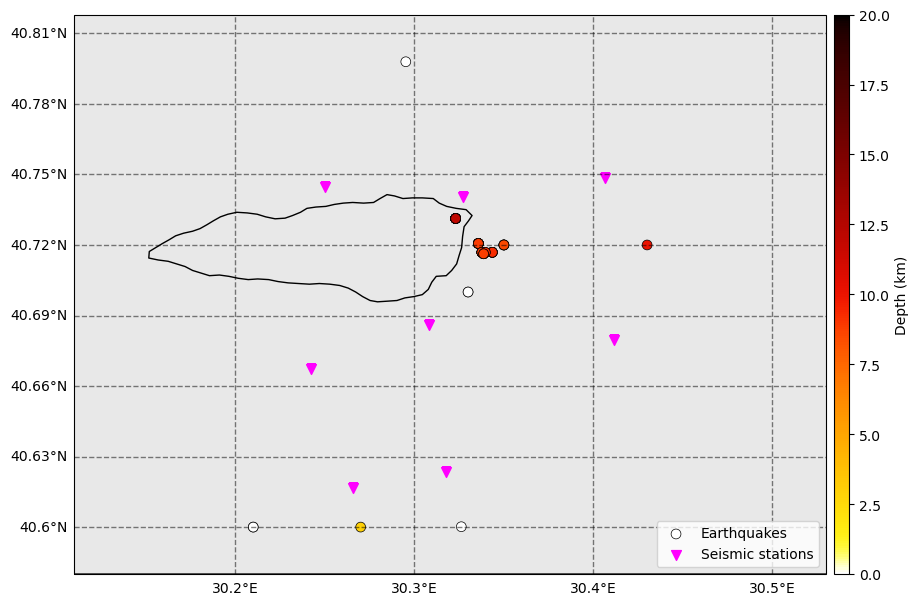

In [12]:
fig = template_group.catalog.plot_map(
    figsize=(10, 10), network=net, s=50, markersize_station=50, lat_margin=0.02, plot_uncertainties=False
    )
ax = fig.get_axes()[0]
ax.set_facecolor("dimgrey")
ax.patch.set_alpha(0.15)

## Bonus: Relocate each events

In your workflow, you might be ok with the approximate locations of the template matching catalog. However, if you decide to keep refining the catalog, here are some suggestions to get started.

One possibility to start refining the locations of all events is to re-run the same process as in notebook 6, namely `PhaseNet` and `NonLinLoc`.

In [13]:
import seisbench.models as sbm

ml_detector = sbm.PhaseNet.from_pretrained("original")
ml_detector.eval()

PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

In [14]:
# PhaseNet picking parameters

# PhaseNet was trained for 100Hz data. Even if we saw that running PhaseNet on 25Hz data
# was good for backprojection, here, picking benefits from running PhaseNet on 100Hz data.
# Thus, we will upsample the waveforms before running PhaseNet.
PHASENET_SAMPLING_RATE_HZ = 100.
UPSAMPLING_BEFORE_PN_RELOCATION = int(PHASENET_SAMPLING_RATE_HZ/BPMF.cfg.SAMPLING_RATE_HZ)
DOWNSAMPLING_BEFORE_PN_RELOCATION = 1

# DURATION_SEC: the duration, in seconds, of the data stream starting at the detection time
#               defined by Event.origin_time. This data stream is used for picking the P/S waves.
DURATION_SEC = 60.0
# THRESHOLD_P: probability of P-wave arrival above which we declare a pick. If several picks are
#              declared during the DURATION_SEC data stream, we only keep the best one. We can
#              afford using a low probability threshold since we already know with some confidence
#              that an earthquake is in the data stream.
THRESHOLD_P = 0.10
# THRESHOLD_S: probability of S-wave arrival above which we declare a pick.
THRESHOLD_S = 0.10
# DATA_FOLDER: name of the folder where the waveforms we want to use for picking are stored
DATA_FOLDER = "preprocessed_2_12"
# COMPONENT_ALIASES: A dictionary that defines the possible channel names to search for
#                    for example, the seismometer might not be oriented and the horizontal channels
#                    might be named 1 and 2, in which case we arbitrarily decide to take 1 as the "N" channel
#                    and 2 as the "E" channel. This doesn't matter for picking P- and S-wave arrival times.
COMPONENT_ALIASES = {"N": ["N", "1"], "E": ["E", "2"], "Z": ["Z"]}
# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform
PHASE_ON_COMP = {"N": "S", "1": "S", "E": "S", "2": "S", "Z": "P"}
# USE_APRIORI_PICKS: boolean. This option is IMPORTANT when running BPMF in HIGH SEISMICITY CONTEXTS, like
#                   during the aftershock sequence of a large earthquake. If there are many events happening
#                   close to each other in time, we need to guide PhaseNet to pick the right set of picks.
#                   For that, we use the predicted P- and S-wave times from backprojection to add extra weight to
#                   the picks closer to those times and make it more likely to identify them as the "best" picks.
#                   WARNING: If there are truly many events, even this trick might fail. It's because "phase association"
#                   is an intrinsically hard problem in this case, and the picking might be hard to do automatically.
USE_APRIORI_PICKS = True
#SEARCH_WIN_SEC: When `use_apriori_picks=True`, the P/S picks in the `DURATION_SEC`-long window are weighted
#                using a gaussian centered on the predicted P/S wave arrivals and with standard deviation
#                equal to `SEARCH_WIN_SEC`. Thus, the picks outside of +/- `3*SEARCH_WIN_SEC` are essentially
#                given a weight of 0.
SEARCH_WIN_SEC = 1.0

# MAX_HORIZONTAL_UNC_KM: Horizontal location uncertainty, in km, above which we keep the template location
MAX_HORIZONTAL_UNC_KM = 10.

# location parameters

LOCATION_ROUTINE = "NLLoc"
# NLLOC_METHOD: string that defines what loss function is used by NLLoc, see http://alomax.free.fr/nlloc/ for more info.
#               Using some flavor of 'EDT' is important to obtain robust locations that are not sensitive to pick outliers.
NLLOC_METHOD = "EDT_OT_WT_ML"
# MINIMUM_NUM_STATIONS_W_PICKS: minimum number of stations with picks to even try relocation.
MINIMUM_NUM_STATIONS_W_PICKS = 3
# we set a maximum tolerable difference, in percentage, between the picked time and the predicted travel time
MAX_TIME_DIFFERENT_PICKS_PREDICTED_PERCENT = 25

In [15]:
events = {}
for i in tqdm(range(len(template_group.catalog.catalog)), desc="Relocating each individual event"):
    row = template_group.catalog.catalog.iloc[i]
    tid, evidx = row.name.split(".")
    # get the template instance from template_group
    template = template_group.templates[template_group.tindexes.loc[int(tid)]]
    # this is the filename of the database where template tid's detected events were stored
    detection_db_filename = f"detections_template{tid}.h5"
    db_path = os.path.join(BPMF.cfg.OUTPUT_PATH, MATCHED_FILTER_DB)
    with h5.File(os.path.join(db_path, detection_db_filename), mode="r") as fdet:
        keys = list(fdet.keys())
        event = BPMF.dataset.Event.read_from_file(
            hdf5_file=fdet[keys[int(evidx)]], data_reader=data_reader_mseed
            )
    # set arrival_times attribute to re-pick P-/S-wave arrivals with prior information
    event.set_arrival_times_from_moveouts(verbose=0)
    # # attach data reader this way (note: conflict with data_reader argument in phasenet's wrapper module)
    # event.data_reader = data_reader_mseed
    # pick P-/S-wave arrivals
    event.pick_PS_phases(
        DURATION_SEC,
        phase_on_comp=PHASE_ON_COMP,
        threshold_P=THRESHOLD_P,
        threshold_S=THRESHOLD_S,
        component_aliases=COMPONENT_ALIASES,
        data_folder=DATA_FOLDER,
        upsampling=UPSAMPLING_BEFORE_PN_RELOCATION,
        downsampling=DOWNSAMPLING_BEFORE_PN_RELOCATION,
        use_apriori_picks=USE_APRIORI_PICKS,
        ml_model=ml_detector,
    )
    if len(event.picks.dropna(how="any")) >= MINIMUM_NUM_STATIONS_W_PICKS:
        # first relocation, insensitive to outliers
        event.relocate(
            stations=net.stations, routine=LOCATION_ROUTINE, method=NLLOC_METHOD,
        )    
    if "NLLoc_reloc" in event.aux_data:
        # this variable was inserted into ev.aux_data if NLLoc successfully located the event
        # use predicted times to remove outlier picks
        event.remove_outlier_picks(max_diff_percent=MAX_TIME_DIFFERENT_PICKS_PREDICTED_PERCENT)
        if len(event.picks.dropna(how="any")) >= MINIMUM_NUM_STATIONS_W_PICKS:
            # first relocation, insensitive to outliers
            event.relocate(
                stations=net.stations, routine=LOCATION_ROUTINE, method=NLLOC_METHOD,
            )
        else:
            del event.aux_data["NLLoc_reloc"]
    events[row.name] = event
    if ("NLLoc_reloc" in event.aux_data) and (event.hmax_unc) < MAX_HORIZONTAL_UNC_KM:
        template_group.catalog.catalog.loc[row.name, "longitude"] = event.longitude
        template_group.catalog.catalog.loc[row.name, "latitude"] = event.latitude
        template_group.catalog.catalog.loc[row.name, "depth"] = event.depth
        template_group.catalog.catalog.loc[row.name, "origin_time"] = event.origin_time
        template_group.catalog.catalog.loc[row.name, "hmax_unc"] = event.hmax_unc
        template_group.catalog.catalog.loc[row.name, "hmin_unc"] = event.hmin_unc
        template_group.catalog.catalog.loc[row.name, "vmax_unc"] = event.vmax_unc
        template_group.catalog.catalog.loc[row.name, "az_hmax_unc"] = event.az_hmax_unc
                                           

Relocating each individual event:   0%|          | 0/63 [00:00<?, ?it/s]

Relocating each individual event: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


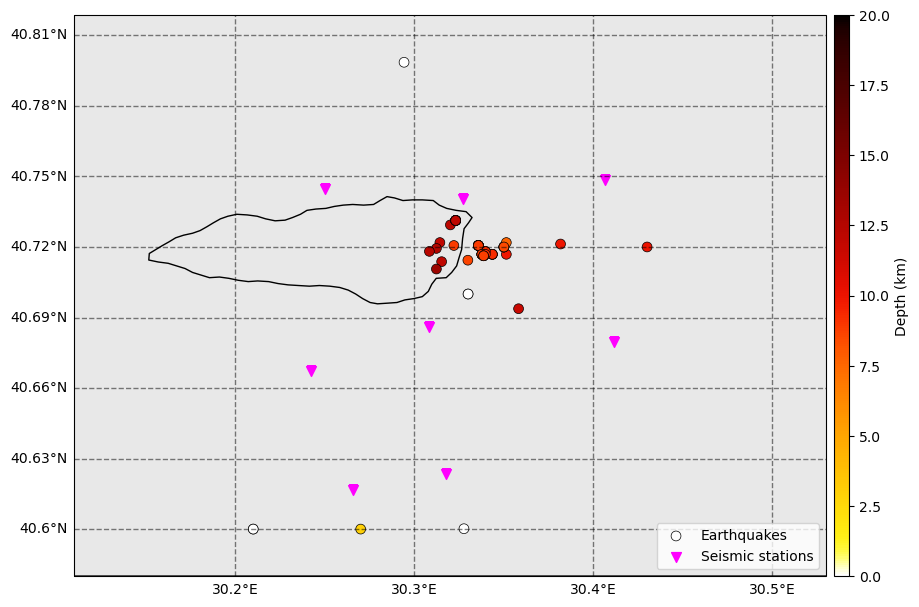

In [16]:
fig = template_group.catalog.plot_map(
    figsize=(10, 10), network=net, s=50, markersize_station=50, lat_margin=0.02, plot_uncertainties=False
    )
ax = fig.get_axes()[0]
ax.set_facecolor("dimgrey")
ax.patch.set_alpha(0.15)

## Assemble the backprojection and template matching catalog 

When selecting the template events from the backprojection catalog, we imposed some quality criteria that might have thrown out some events that we still want in our final catalog. Here, we make a simple comparison of the backprojection and template matching catalogs to find these missing events and add them to the final catalog.

In [17]:
BACKPROJECTION_CATALOG_FILENAME = "backprojection_catalog.csv"

In [18]:
tm_catalog = template_group.catalog.catalog.copy()
tm_catalog.reset_index(inplace=True)
for i in range(len(tm_catalog)):
    tm_catalog.loc[i, "event_id"] = f"tm_{tm_catalog.loc[i, 'event_id']}"
tm_catalog

,event_id,longitude,latitude,depth,origin_time,cc,tid,return_time,origin_time_sec,interevent_time_sec,unique_event,hmax_unc,hmin_unc,az_hmax_unc,vmax_unc
0,tm_2.0,30.210000,40.600000,-1.500000,2012-07-26 00:20:46.080000,0.355306,2,NaN,1.343262e+09,0.00,True,NaN,NaN,NaN,NaN
1,tm_10.0,30.337695,40.716875,8.867188,2012-07-26 00:58:11.120000,0.342251,10,NaN,1.343264e+09,0.04,True,NaN,NaN,NaN,NaN
2,tm_0.1,30.323047,40.731250,12.015625,2012-07-26 00:58:16.160000,0.307403,0,5.52,1.343264e+09,5.04,True,NaN,NaN,NaN,NaN
3,tm_0.2,30.323047,40.731250,12.015625,2012-07-26 01:02:52.920000,0.283410,0,276.76,1.343265e+09,276.24,True,NaN,NaN,NaN,NaN
4,tm_1.3,30.343555,40.716875,9.273438,2012-07-26 01:03:46.920000,0.403296,1,53.64,1.343265e+09,0.36,True,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,tm_5.13,30.339648,40.716875,9.273438,2012-07-26 14:49:28.560000,0.231381,5,638.00,1.343314e+09,636.20,True,NaN,NaN,NaN,NaN
59,tm_11.0,30.327686,40.600156,-1.974609,2012-07-26T15:06:20.160000Z,1.000000,11,NaN,1.343315e+09,1011.60,True,1.204434,0.549646,90.198577,1.38049
60,tm_7.3,30.338672,40.716250,8.765625,2012-07-26 16:26:52.560000,0.250604,7,22768.84,1.343320e+09,4832.40,True,NaN,NaN,NaN,NaN
61,tm_7.4,30.338672,40.716250,8.765625,2012-07-26 16:33:57.680000,0.171082,7,425.12,1.343320e+09,425.12,True,NaN,NaN,NaN,NaN


In [19]:
bp_catalog = pd.read_csv(
    os.path.join(BPMF.cfg.OUTPUT_PATH, BACKPROJECTION_CATALOG_FILENAME),
    index_col=0
)
# convert origin times from string to pandas.Timestamp
bp_catalog["origin_time"] = pd.to_datetime(bp_catalog["origin_time"])
bp_catalog

,longitude,latitude,depth,origin_time,hmax_unc,hmin_unc,az_hmax_unc,vmax_unc,event_id.1
event_id,,,,,,,,,
2012-07-26T01:10:21.800000Z,30.323047,40.731250,12.015625,2012-07-26 01:10:21.800,1.733366,1.182667,157.271635,2.640251,bp_0
2012-07-26T01:15:54.160000Z,30.343555,40.716875,9.273438,2012-07-26 01:15:54.160,2.070620,1.108417,90.435851,2.250307,bp_1
2012-07-26T01:58:19.720000Z,30.210000,40.600000,-1.500000,2012-07-26 01:58:19.720,0.968885,0.833068,11.277525,2.155680,bp_2
2012-07-26T02:35:01.160000Z,30.330000,40.700000,-1.500000,2012-07-26 02:35:01.160,4.140636,2.593994,72.951755,4.445532,bp_3
2012-07-26T03:00:39.160000Z,30.324023,40.715625,9.070312,2012-07-26 03:00:39.160,1.812523,1.146382,96.893951,3.431834,bp_4
2012-07-26T04:43:40.160000Z,30.350000,40.720000,8.500000,2012-07-26 04:43:40.160,15.000000,15.000000,0.000000,15.000000,bp_5
2012-07-26T04:48:38.640000Z,30.339648,40.716875,9.273438,2012-07-26 04:48:38.640,2.689873,1.357818,77.828681,3.859434,bp_6
2012-07-26T08:08:25.680000Z,30.335742,40.720625,8.867188,2012-07-26 08:08:25.680,2.457855,1.324990,80.384442,3.851911,bp_7
2012-07-26T10:07:23.720000Z,30.338672,40.716250,8.765625,2012-07-26 10:07:23.720,1.642315,0.946182,93.504006,2.522272,bp_8


In [20]:
# catalog merging parameters
dt_criterion_pd = pd.Timedelta(DT_CRITERION_SEC, "s")
HMAX_UNC_CRITERION_KM = 10.

In [21]:
combined_catalog = tm_catalog.copy()
missing_event = np.zeros(len(bp_catalog), dtype=bool)

for i in tqdm(range(len(bp_catalog)), desc="Loop through BP cat"):
    if bp_catalog.iloc[i]["hmax_unc"] > HMAX_UNC_CRITERION_KM:
        continue
    t_min = bp_catalog.iloc[i]["origin_time"] - dt_criterion_pd
    t_max = bp_catalog.iloc[i]["origin_time"] + dt_criterion_pd
    subset_tm = (tm_catalog["origin_time"] > t_min) & (tm_catalog["origin_time"] < t_max)
    if np.sum(subset_tm) == 0:
        missing_event[i] = True

combined_catalog = pd.concat(
        (tm_catalog, bp_catalog[missing_event]),
        ignore_index=True
        )
combined_catalog.sort_values(
        "origin_time", ascending=True, inplace=True
        )

Loop through BP cat: 100%|██████████| 17/17 [00:00<00:00, 1134.01it/s]


And here is the combined catalog! In this simple example, it appears that all events in the backprojection catalog were re-detected in the template matching catalog so that the final catalog has no extra events with respect to the template matching catalog. However, it may not be always like that. Some events in the backprojection catalog may not have been well enough located for you to use them as templates, and they may not have been subsequently re-detected in the template matching catalog.

In [22]:
combined_catalog

,event_id,longitude,latitude,depth,origin_time,cc,tid,return_time,origin_time_sec,interevent_time_sec,unique_event,hmax_unc,hmin_unc,az_hmax_unc,vmax_unc,event_id.1
0,tm_2.0,30.210000,40.600000,-1.500000,2012-07-26 00:20:46.080000,0.355306,2.0,NaN,1.343262e+09,0.00,True,NaN,NaN,NaN,NaN,NaN
1,tm_10.0,30.337695,40.716875,8.867188,2012-07-26 00:58:11.120000,0.342251,10.0,NaN,1.343264e+09,0.04,True,NaN,NaN,NaN,NaN,NaN
2,tm_0.1,30.323047,40.731250,12.015625,2012-07-26 00:58:16.160000,0.307403,0.0,5.52,1.343264e+09,5.04,True,NaN,NaN,NaN,NaN,NaN
3,tm_0.2,30.323047,40.731250,12.015625,2012-07-26 01:02:52.920000,0.283410,0.0,276.76,1.343265e+09,276.24,True,NaN,NaN,NaN,NaN,NaN
4,tm_1.3,30.343555,40.716875,9.273438,2012-07-26 01:03:46.920000,0.403296,1.0,53.64,1.343265e+09,0.36,True,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,tm_5.13,30.339648,40.716875,9.273438,2012-07-26 14:49:28.560000,0.231381,5.0,638.00,1.343314e+09,636.20,True,NaN,NaN,NaN,NaN,NaN
59,tm_11.0,30.327686,40.600156,-1.974609,2012-07-26T15:06:20.160000Z,1.000000,11.0,NaN,1.343315e+09,1011.60,True,1.204434,0.549646,90.198577,1.38049,NaN
60,tm_7.3,30.338672,40.716250,8.765625,2012-07-26 16:26:52.560000,0.250604,7.0,22768.84,1.343320e+09,4832.40,True,NaN,NaN,NaN,NaN,NaN
61,tm_7.4,30.338672,40.716250,8.765625,2012-07-26 16:33:57.680000,0.171082,7.0,425.12,1.343320e+09,425.12,True,NaN,NaN,NaN,NaN,NaN


In this example, we see that two entries of the catalog end up pointing to the same event (see below):

In [23]:
combined_catalog[
    (combined_catalog["origin_time"] >= pd.Timestamp("2012-07-26T13:40:00"))
    &
    (combined_catalog["origin_time"] <= pd.Timestamp("2012-07-26T13:50:00"))
]

,event_id,longitude,latitude,depth,origin_time,cc,tid,return_time,origin_time_sec,interevent_time_sec,unique_event,hmax_unc,hmin_unc,az_hmax_unc,vmax_unc,event_id.1
51,tm_0.32,30.312305,40.719375,12.523438,2012-07-26T13:48:32.400000Z,0.193654,0.0,18.88,1.343311e+09,16.68,True,1.694781,1.424041,-159.166753,3.097528,NaN
50,tm_0.31,30.314258,40.721875,11.914062,2012-07-26T13:48:32.440000Z,0.733365,0.0,20407.12,1.343311e+09,785.84,True,1.507701,1.363615,-142.318562,2.908710,NaN


**versus** (before relocating each event individually)

In [24]:
initial_catalog[
    (initial_catalog["origin_time"] >= pd.Timestamp("2012-07-26T13:40:00"))
    &
    (initial_catalog["origin_time"] <= pd.Timestamp("2012-07-26T13:50:00"))
]

,longitude,latitude,depth,origin_time,cc,tid,return_time,origin_time_sec,interevent_time_sec,unique_event
event_id,,,,,,,,,,
0.31,30.323047,40.73125,12.015625,2012-07-26 13:48:32.320,0.733365,0,20407.12,1.343311e+09,785.84,True
0.32,30.323047,40.73125,12.015625,2012-07-26 13:48:51.200,0.193654,0,18.88,1.343311e+09,16.68,True


This is because, despite using the `use_apriori_picks=True`, the automatic picking ended up picking the event before `tm_0.33`. So, before I release a fix to this issue, we need to clean up these redundant catalog entries! And keep in mind that the initial template matching catalog might have better temporal resolution.

## Last clean up

In [25]:
final_cat = combined_catalog.copy()
final_cat["origin_time_sec"] = (
        final_cat["origin_time"].values.astype("datetime64[ms]").astype("float64") / 1000.
        )

num_removed = -1
iteration = 0
while num_removed != 0:
    print(f"------ Iteration {iteration} --------")
    interevent_time_sec = (
            final_cat["origin_time_sec"].values[1:] - final_cat["origin_time_sec"].values[:-1]
            )
    interevent_time_sec = np.hstack( (1000., interevent_time_sec) )
    remove = np.zeros(len(final_cat), dtype=bool)
    for i in np.where(interevent_time_sec < DT_CRITERION_SEC)[0]:
        dist = BPMF.utils.two_point_epicentral_distance(
                final_cat.iloc[i-1].longitude,
                final_cat.iloc[i-1].latitude,
                final_cat.iloc[i].longitude,
                final_cat.iloc[i].latitude,
                )
        if dist < DISTANCE_CRITERION_KM:
            if final_cat.iloc[i-1].hmax_unc < final_cat.iloc[i].hmax_unc:
                remove[i] = True
            else:
                remove[i-1] = True
    num_removed = np.sum(remove)
    print(f"Removed {num_removed} events. Examples:")
    if num_removed > 1:
        removed_events = np.where(remove)[0]
        print(final_cat[["origin_time", "event_id", "longitude", "latitude"]].iloc[removed_events[0]])
        if interevent_time_sec[removed_events[0]] < DT_CRITERION_SEC:
            print(final_cat[["origin_time", "event_id", "longitude",
                "latitude"]].iloc[removed_events[0] - 1])
        else:
            print(final_cat[["origin_time", "event_id", "longitude",
                "latitude"]].iloc[removed_events[0] + 1])

    final_cat = final_cat[~remove]
    iteration += 1


------ Iteration 0 --------
Removed 3 events. Examples:
origin_time    2012-07-26T01:15:14.320000Z
event_id                            tm_0.9
longitude                        30.381641
latitude                          40.72125
Name: 10, dtype: object
origin_time    2012-07-26T01:15:15.000000Z
event_id                            tm_1.9
longitude                        30.329883
latitude                         40.714375
Name: 11, dtype: object
------ Iteration 1 --------
Removed 0 events. Examples:


In [26]:
final_cat.set_index("event_id", drop=False, inplace=True)
final_cat.drop(columns=["interevent_time_sec", "unique_event", "origin_time_sec"], inplace=True)
final_cat.sort_values("origin_time", ascending=True, inplace=True)
final_cat

,event_id,longitude,latitude,depth,origin_time,cc,tid,return_time,hmax_unc,hmin_unc,az_hmax_unc,vmax_unc,event_id.1
event_id,,,,,,,,,,,,,
tm_2.0,tm_2.0,30.210000,40.600000,-1.500000,2012-07-26 00:20:46.080000,0.355306,2.0,NaN,NaN,NaN,NaN,NaN,NaN
tm_10.0,tm_10.0,30.337695,40.716875,8.867188,2012-07-26 00:58:11.120000,0.342251,10.0,NaN,NaN,NaN,NaN,NaN,NaN
tm_0.1,tm_0.1,30.323047,40.731250,12.015625,2012-07-26 00:58:16.160000,0.307403,0.0,5.52,NaN,NaN,NaN,NaN,NaN
tm_0.2,tm_0.2,30.323047,40.731250,12.015625,2012-07-26 01:02:52.920000,0.283410,0.0,276.76,NaN,NaN,NaN,NaN,NaN
tm_1.3,tm_1.3,30.343555,40.716875,9.273438,2012-07-26 01:03:46.920000,0.403296,1.0,53.64,NaN,NaN,NaN,NaN,NaN
tm_0.4,tm_0.4,30.323047,40.731250,12.015625,2012-07-26 01:09:15.880000,0.210914,0.0,329.32,NaN,NaN,NaN,NaN,NaN
tm_10.3,tm_10.3,30.337695,40.716875,8.867188,2012-07-26 01:09:26,0.290443,10.0,338.96,NaN,NaN,NaN,NaN,NaN
tm_0.6,tm_0.6,30.320117,40.729375,12.117188,2012-07-26T01:10:21.840000Z,1.000000,0.0,56.28,1.773194,1.296419,154.710273,2.652053,NaN
tm_10.5,tm_10.5,30.337695,40.716875,8.867188,2012-07-26 01:10:44.080000,0.590581,10.0,21.76,NaN,NaN,NaN,NaN,NaN


## Save final catalog

In [27]:
# csv format
final_cat.to_csv(
    os.path.join(BPMF.cfg.OUTPUT_PATH, OUTPUT_CSV_FILENAME)
)

In [28]:
# hdf5 / BPMF format
for i in range(len(final_cat)):
    evid = final_cat.iloc[i]["event_id"]
    if evid[:2] == "tm":
        events[evid.split("_")[1]].write(
            OUTPUT_DB_FILENAME,
            db_path=BPMF.cfg.OUTPUT_PATH,
            gid=evid
        )
    elif evid[:2] == "bp":
        with h5.File(os.path.join(BPMF.cfg.OUTPUT_PATH, OUTPUT_DB_FILENAME), mode="a") as fout:
            with h5.File(os.path.join(BPMF.cfg.OUTPUT_PATH, BACKPROJ_DB_FILENAME), mode="r") as fin:
                # copy the corresponding hdf5 group into fout
                fin.copy(fin[evid], fout)

In [29]:
# The final cat!
BPMF.utils.donefun()

⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⠀⠀⢀⡤⣤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⡀⠀⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⠀⢀⡏⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⣀⠴⠋⠉⠉⡆⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠈⠉⠉⠙⠓⠚⠁⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⢀⠞⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣄⠀⠀⠀⠀
    ⠀⠀⠀⠀⡞⠀⠀⠀⠀⠀⠶⠀⠀⠀⠀⠀⠀⠦⠀⠀⠀⠀⠀⠸⡆⠀⠀⠀
    ⢠⣤⣶⣾⣧⣤⣤⣀⡀⠀⠀⠀⠀⠈⠀⠀⠀⢀⡤⠴⠶⠤⢤⡀⣧⣀⣀⠀
    ⠻⠶⣾⠁⠀⠀⠀⠀⠙⣆⠀⠀⠀⠀⠀⠀⣰⠋⠀⠀⠀⠀⠀⢹⣿⣭⣽⠇
    ⠀⠀⠙⠤⠴⢤⡤⠤⠤⠋⠉⠉⠉⠉⠉⠉⠉⠳⠖⠦⠤⠶⠦⠞⠁⠀⠀⠀
                ⠀ALL DONE!⠀⠀⠀
    
